# Sample Recommendation - Obscure Orwell Book
This notebook explores end-to-end workflow for an example recommendation without going especially deep into one aspect of the workflow.

An obscure Orwell book was chosen for this workflow for a few reasons:
- To test the lower end of a recommendation algorithm. How few reviews does a product need for a decent recommendation?
    - Answer: about 10
- To provide a simple baseline example that is easy to understand
- Books were chosen over music because our book data is high-quality
- A popular author like Orwell was chosen so that we can calibrate how obscure of a book we want

In [82]:
%load_ext autoreload
%autoreload 

import math
import sqlite3 as sql
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import sparse
from sklearn.metrics import pairwise_distances

import shared.viz as viz
import shared.query as q
import shared.format as fmt
import shared.reviews as rev

viz.set_style()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [83]:
conn = sql.connect('data/products.sql')

## Orwell Book Overview

Let's begin by getting an overview of George Orwell books by number of reviewers. Then choosing an obscure Orwell book to stress-test recommendations on the lower end.

In [84]:
q.query(f"""
SELECT id, p.title, p.title_search, COUNT(*) AS reviews
FROM review r JOIN product p ON r.product_id = p.id
WHERE p.category = ? AND p.creator = ?
GROUP BY p.id
ORDER BY reviews DESC
""", conn, params = ['Books', 'George Orwell'], query_description = 'Orwell Books by Popularity').drop(columns = ['title_search'])

Orwell Books by Popularity: 33 results in 0.321 seconds


,id,title,reviews
0,9562910334,1984,1860
1,B000GROP62,Nineteen Eighty-four,1859
2,B000NHNM3C,George Orwell 1984,1844
3,B000N79NHQ,Animal Farm 50TH Anniversary Edition,1413
4,B0007BY9UY,Homage to Catalonia,153
5,184046254X,George Orwell: Animal Farm-Nineteen Eighty-Four,147
6,9568530428,Animal Farm and 1984,147
7,B0006CZLYW,Animal Farm & 1984 (Collected Stories of the W...,142
8,B000855W9G,"Down and out in Paris and London,",132
9,0786102950,Burmese Days: A Novel (Library Edition),83


## Book Retrieval

Verify that when we enter a book title, we can find a matching book``

In [85]:
title = 'Orwell Reader'
product = q.find_products('Books', title, conn, exact_match = False).iloc[0]
product

find_products: 1 results in 0.289 seconds


id                                                     B0007E09V4
reviews                                                        10
title           The Orwell reader: Fiction, essays, and report...
creator                                             George Orwell
publisher                               Houghton Mifflin Harcourt
description     Selections reveal the development of Orwell's ...
release_date                                                 1956
category                                                    Books
subcategory                                    Literary Criticism
Name: 0, dtype: object

## Ratings + Reviews
Explore user ratings + reviews including metadata on review helpfulness

In [86]:
reviews = q.get_reviews(product.id, conn)
reviews

get_reviews: 10 results in 0.002 seconds


,user_id,product_id,title,review,rating,upvotes,downvotes,timestamp
0,A2E0N4JR8M3M5O,B0007E09V4,Homage to Orwell,The honesty and realism of Orwell never ceases...,5,21,3,1154822400
1,A2E9TRM8096BXU,B0007E09V4,A Moveable Feast,The blurb on the back of the book calls THE GE...,5,8,0,1210118400
2,A38JN189EJK91M,B0007E09V4,Fiction Fragments...,I am no stranger to the sin of pride. I pride ...,3,3,1,1244505600
3,A3SJZN8N1NJCLQ,B0007E09V4,The Orwell Reader,A must read. Really. There are a couple of peo...,5,0,0,1348272000
4,A2HFQ405AKX4IW,B0007E09V4,The Great Prophet,This book taught: That 1984 was correct and on...,5,0,0,1347840000
5,AJKYSKZCA1NG1,B0007E09V4,"A bit misleading, but still good",Product that was delieverd was from an older p...,4,0,0,1312156800
6,AVGOBCHN3V2VT,B0007E09V4,Amazing Introduction to Orwell. But buy the or...,This book has been my introduction to Orwell. ...,5,1,1,1206489600
7,A1CYRTQ04LYI55,B0007E09V4,The originals in their entirety are more appro...,I was disappointed with this compendium of the...,3,6,5,1094688000
8,A2BL9PXIL915Q6,B0007E09V4,Correction to previous post,"Er, actually Orwell did fight on the Republica...",5,3,6,940464000
9,None,B0007E09V4,Material not normally found,Bad point: according to be back of the book Or...,4,1,28,940032000


In [87]:
print ("REVIEWS BY HELPFULNESS")
sorted_reviews = rev.sort_reviews(reviews, include_quality = True)[['upvotes', 'downvotes', 'quality', 'rating', 'title', 'review']]
sorted_reviews

REVIEWS BY HELPFULNESS


,upvotes,downvotes,quality,rating,title,review
0,21,3,3.130952,5,Homage to Orwell,The honesty and realism of Orwell never ceases...
1,8,0,2.462963,5,A Moveable Feast,The blurb on the back of the book calls THE GE...
2,3,1,1.296875,3,Fiction Fragments...,I am no stranger to the sin of pride. I pride ...
7,6,5,1.086538,3,The originals in their entirety are more appro...,I was disappointed with this compendium of the...
6,1,1,0.984375,5,Amazing Introduction to Orwell. But buy the or...,This book has been my introduction to Orwell. ...
3,0,0,0.981481,5,The Orwell Reader,A must read. Really. There are a couple of peo...
4,0,0,0.981481,5,The Great Prophet,This book taught: That 1984 was correct and on...
5,0,0,0.981481,4,"A bit misleading, but still good",Product that was delieverd was from an older p...
8,3,6,0.728070,5,Correction to previous post,"Er, actually Orwell did fight on the Republica..."
9,1,28,0.188623,4,Material not normally found,Bad point: according to be back of the book Or...


In [88]:
print("Best review:")
print(sorted_reviews.iloc[0].review.replace('.', '.\n'))

Best review:
The honesty and realism of Orwell never ceases to amaze.
 He opens 'Shooting an Elephant', the first story in this collection, by telling us that he was hated by many people.
 He will spend the rest of the essay showing us why.
 The pointless death of an animal no longer harmful becomes the legal murder we witness in 'A Hanging'.
 In both cases we see people becoming their jobs, counting doing one's duty more important than being human.
He sees "the dirty work of Empire at close quarters" and knows that " imperialism is an evil thing" but continues to do his duty as both imperialist and colonist would see it.
 The amazing thing is that he is not alone in this.
 In "A Hanging" the hangman is a convict and after the deed is done we see both Europeans and natives laughing and drinking together.
 In "Shooting an Elephant" he is stuck between "hatred of the empire" and "rage against the evil-spirited little beasts" that made his job impossible.
 But again, we witness crowds of 

RATINGS:


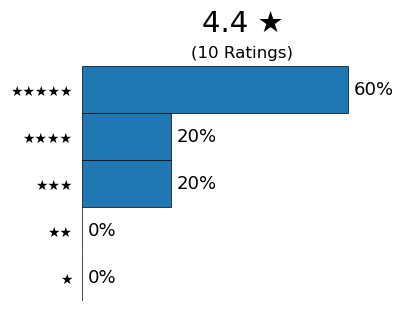

In [89]:

print("RATINGS:")
plt.figure(figsize = (4,3))
viz.plot_ratings(reviews.rating)  

## Item-based Recommendations
Let's find similar products to this one based on user reviews.

In other words: users who liked this also liked ...

#### Get Related Reviews
Enumerate all books that have reviewers in common with the starting book:

In [90]:

# SELECT user_id, product_id, rating FROM review WHERE user_id IN (unique users in reviews)
related_reviews = q.get_records_by_ids(
    ids = reviews.user_id.dropna().unique(), 
    select = 'user_id, product_id, rating', table = 'review', id_column = 'user_id', 
    connection = conn
)
related_reviews

review.user_id lookup (9 values): 363 results in 0.004 seconds


,user_id,product_id,rating
0,A1CYRTQ04LYI55,0026276615,5
1,A1CYRTQ04LYI55,0060298480,5
2,A1CYRTQ04LYI55,006052944X,5
3,A1CYRTQ04LYI55,0066620694,4
4,A1CYRTQ04LYI55,0130336297,4
...,...,...,...
358,A38JN189EJK91M,B000QBCGIW,3
359,A38JN189EJK91M,B000TZ19TC,5
360,A3SJZN8N1NJCLQ,B0007E09V4,5
361,AJKYSKZCA1NG1,B0007E09V4,4


In [91]:
print(f'Unique users: {len(related_reviews.user_id.unique())}')
print(f'Unique books: {len(related_reviews.product_id.unique())}')

Unique users: 9
Unique books: 340


#### Compute Cosine Similarities
Finally, use cosine similarities to make recommendations

In [92]:
user_ratings_per_product = pd.pivot(
    related_reviews,
    values = 'rating',
    index = 'product_id',
    columns = 'user_id'
)
user_ratings_per_product

user_id,A1CYRTQ04LYI55,A2BL9PXIL915Q6,A2E0N4JR8M3M5O,A2E9TRM8096BXU,A2HFQ405AKX4IW,A38JN189EJK91M,A3SJZN8N1NJCLQ,AJKYSKZCA1NG1,AVGOBCHN3V2VT
product_id,,,,,,,,,
0003300277,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN
0025306502,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN
0026276615,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0027085201,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN
0060084332,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
B000Q8QIRU,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
B000QBCGIW,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN
B000RAIQS6,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN


In [93]:
fill_value = 0
user_ratings_per_product_sparse = sparse.csr_matrix(user_ratings_per_product.fillna(fill_value))
user_ratings_per_product_sparse

<340x9 sparse matrix of type '<class 'numpy.float64'>'
	with 363 stored elements in Compressed Sparse Row format>

In [94]:
# compute pairwise cosine similarities
# The resulting entries represent the cosine of the angles between the movie review vectors of two movies.
# A cosine similarity of 1 represents identical products while a cosine similarity of 0 represents orthogonal / unrelated products
pairwise_cosine_similarities = pairwise_distances(user_ratings_per_product_sparse, metric = 'cosine')
pairwise_cosine_similarities

array([[0., 1., 1., ..., 1., 0., 1.],
       [1., 0., 1., ..., 1., 1., 1.],
       [1., 1., 0., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 0., 1., 0.],
       [0., 1., 1., ..., 1., 0., 1.],
       [1., 1., 1., ..., 0., 1., 0.]])

In [95]:
# convert to user-readable results oriented around the target movie
recommendations = pd.DataFrame(pairwise_cosine_similarities, index = user_ratings_per_product.index, columns = user_ratings_per_product.index)
# recommended products sorted by most similar
recommendations = recommendations.loc[product.id].sort_values(ascending = True)
# add product data for user-facing resuls. We only have product Ids.

recommendations

product_id
B0007E09V4    0.000000
B0000CLBGM    0.572418
0786102985    0.582971
B000FC2QGE    0.582971
B0007BY9UY    0.582971
                ...   
B0006IU3E4    0.778837
B0006YNBPQ    0.778837
B0007379RC    0.778837
158118011X    0.778837
B0007ERI68    0.778837
Name: B0007E09V4, Length: 340, dtype: float64

In [96]:
best_recommendations = q.get_product_details(recommendations.index[:10], conn)
pd.concat([recommendations[:10], best_recommendations], axis = 1).rename(columns = {product.id: 'score'})

product details 10: 10 results in 0.002 seconds


,score,title,title_search,creator,creator_search,publisher,description,category,subcategory,release_date
B0007E09V4,0.000000,"The Orwell reader: Fiction, essays, and report...",orwellreaderfictionessaysandreportageharvestbook,George Orwell,georgeorwell,Houghton Mifflin Harcourt,Selections reveal the development of Orwell's ...,Books,Literary Criticism,1956
B0000CLBGM,0.572418,Coming Up for Air,comingupforair,George Orwell,georgeorwell,"Oxford University Press, USA","Set at the beginning of the Second World War, ...",Books,Fiction,2021-01-07
0786102985,0.582971,Homage to Catalonia (Library Edition),homagetocatalonialibraryedition,nan,nan,None,None,Books,nan,None
B000FC2QGE,0.582971,Blink: The Power of Thinking Without Thinking,blinkpowerofthinkingwithoutthinking,Malcolm Gladwell,malcolmgladwell,Back Bay Books,From the #1 bestselling author of The Bomber M...,Books,Business & Economics,2007-04-03
B0007BY9UY,0.582971,Homage to Catalonia,homagetocatalonia,George Orwell,georgeorwell,Pan Macmillan,Homage to Catalonia remains one of the most fa...,Books,Biography & Autobiography,2021-03-04
B000KQK1TO,0.582971,The Road to Wigan Pier,roadtowiganpier,George Orwell,georgeorwell,epubli,"""The Road to Wigan Pier"" is a book by the Engl...",Books,Fiction,2021-01-09
0816157871,0.597035,Native Son (G K Hall Large Print Book Series),nativesongkhalllargeprintbookseries,nan,nan,None,None,Books,nan,None
B000N7LO50,0.597035,KEEP THE ASPIDISTRA FLYING,keepaspidistraflying,George Orwell,georgeorwell,Harper Collins,"Waging a losing war with the Money God, Gordon...",Books,Fiction,2012-06-19
B000JL7VUM,0.597035,Keep the Aspidistra Flying,keepaspidistraflying,George Orwell,georgeorwell,Harper Collins,"Waging a losing war with the Money God, Gordon...",Books,Fiction,2012-06-19
B00085TMH4,0.601907,"Burmese days;: A novel,",burmesedaysanovel,George Orwell,georgeorwell,HarperCollins,"Honest and evocative, George Orwell’s first no...",Books,Fiction,1974-03-20


#### Evaluation - Book Recommendations

These are quite promising initial results. The recommendation algorithm recommended a variety of lesser-known Orwell books much like the original input despite the low volumes of data, and despite the algorithm being author agnostic. Also, computations were near-instantaneous. 

Notably absent from top recommendations are Orwell's well-known works. Though this may be seen as a gap, one could also reasonably argue that an obscure Orwell book is more similar to the input - an obscure Orwell book - than a well-known Orwell book would be.

We have a duplication problem in our data set, with two near-identical variations of Keep the Aspidistra Flying. Though this is unrelated to the recommendation algorithm, we could use a pre-processing phase that merges duplicate products.

Malcom Gladwell's Blink interestingly made the list. Though unrelated to Orwell or politics, it is conceivable that nonfiction aficionados would be into both Orwell essays and Blink. Still, the inclusion of a bestseller on a list of otherwise obscure books seems odd.

## Close Connection

In [97]:
conn.close()